# 📊 AQI Predictor - Exploratory Data Analysis (EDA)

This notebook explores the air quality and weather data collected for Karachi.

## Objectives:
1. Load data from Hopsworks
2. Understand data distribution
3. Identify trends and patterns
4. Analyze correlations
5. Detect seasonality
6. Identify anomalies


In [3]:
# Import libraries
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Add parent directory to path
sys.path.append('..')

from feature_pipeline.hopsworks_utils import connect_to_hopsworks, get_features_for_training

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries imported successfully!")

✓ Libraries imported successfully!


## 1️⃣ Load Data from Hopsworks

In [4]:
# Connect to Hopsworks
project = connect_to_hopsworks()

# Load features
df = get_features_for_training(project, feature_group_name="aqi_features", version=1)

print(f"✓ Loaded {len(df)} records")
print(f"  Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"  Features: {len(df.columns)}")


🔗 Connecting to Hopsworks...
2026-02-01 18:16:29,455 INFO: Closing external client and cleaning up certificates.
Connection closed.
2026-02-01 18:16:29,467 INFO: Initializing external client
2026-02-01 18:16:29,469 INFO: Base URL: https://c.app.hopsworks.ai:443
2026-02-01 18:16:31,822 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1361045
✓ Connected to project: AQIPREDICTOR234
📥 Retrieving features from aqi_features...
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.93s) 
✓ Retrieved 1 records
✓ Loaded 1 records
  Date range: 2026-02-01 16:04:03+00:00 to 2026-02-01 16:04:03+00:00
  Features: 21


In [5]:
# Display first few rows
df.head()

,city,timestamp,temperature,humidity,pressure,wind_speed,pm2_5,pm10,co,no2,...,o3,aqi,hour,day_of_week,day,month,is_weekend,is_rush_hour,pm_ratio,temp_humidity_interaction
0,Karachi,2026-02-01 16:04:03+00:00,24.2,64,1016.7,16.9,44.3,94.6,273.21,0.6,...,133.64,3,16,6,1,2,1,0,0.468288,1548.8


In [6]:
# Data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype                  
---  ------                     --------------  -----                  
 0   city                       1 non-null      object                 
 1   timestamp                  1 non-null      datetime64[us, Etc/UTC]
 2   temperature                1 non-null      float64                
 3   humidity                   1 non-null      int64                  
 4   pressure                   1 non-null      float64                
 5   wind_speed                 1 non-null      float64                
 6   pm2_5                      1 non-null      float64                
 7   pm10                       1 non-null      float64                
 8   co                         1 non-null      float64                
 9   no2                        1 non-null      float64                
 10  so2                        1 n

## 2️⃣ Data Quality Check

In [7]:
# Check for missing values
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

if len(missing) > 0:
    print("Missing values:")
    print(missing)
else:
    print("✓ No missing values!")

✓ No missing values!


In [8]:
# Basic statistics
df.describe()

,temperature,humidity,pressure,wind_speed,pm2_5,pm10,co,no2,so2,o3,aqi,hour,day_of_week,day,month,is_weekend,is_rush_hour,pm_ratio,temp_humidity_interaction
count,1.0,1.0,1.0,1.0,1.0,1.0,1.00,1.0,1.00,1.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0
mean,24.2,64.0,1016.7,16.9,44.3,94.6,273.21,0.6,6.27,133.64,3.0,16.0,6.0,1.0,2.0,1.0,0.0,0.468288,1548.8
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,24.2,64.0,1016.7,16.9,44.3,94.6,273.21,0.6,6.27,133.64,3.0,16.0,6.0,1.0,2.0,1.0,0.0,0.468288,1548.8
25%,24.2,64.0,1016.7,16.9,44.3,94.6,273.21,0.6,6.27,133.64,3.0,16.0,6.0,1.0,2.0,1.0,0.0,0.468288,1548.8
50%,24.2,64.0,1016.7,16.9,44.3,94.6,273.21,0.6,6.27,133.64,3.0,16.0,6.0,1.0,2.0,1.0,0.0,0.468288,1548.8
75%,24.2,64.0,1016.7,16.9,44.3,94.6,273.21,0.6,6.27,133.64,3.0,16.0,6.0,1.0,2.0,1.0,0.0,0.468288,1548.8
max,24.2,64.0,1016.7,16.9,44.3,94.6,273.21,0.6,6.27,133.64,3.0,16.0,6.0,1.0,2.0,1.0,0.0,0.468288,1548.8


## 3️⃣ AQI Distribution and Trends

In [9]:
# Filter out placeholder data (AQI = 0)
df_real = df[df['aqi'] > 0].copy()
print(f"Records with real AQI data: {len(df_real)} ({len(df_real)/len(df)*100:.1f}%)")

Records with real AQI data: 1 (100.0%)


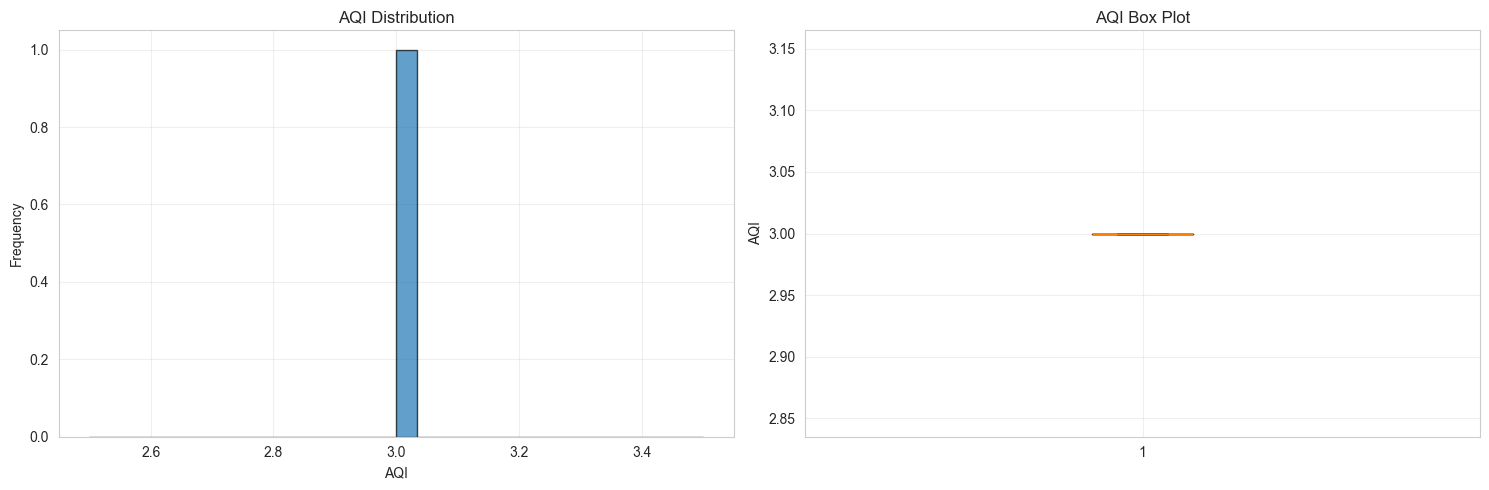

AQI Statistics:
  Mean: 3.00
  Median: 3.00
  Min: 3.00
  Max: 3.00
  Std: nan


In [10]:
# AQI distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(df_real['aqi'], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('AQI')
axes[0].set_ylabel('Frequency')
axes[0].set_title('AQI Distribution')
axes[0].grid(True, alpha=0.3)

# Box plot
axes[1].boxplot(df_real['aqi'])
axes[1].set_ylabel('AQI')
axes[1].set_title('AQI Box Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"AQI Statistics:")
print(f"  Mean: {df_real['aqi'].mean():.2f}")
print(f"  Median: {df_real['aqi'].median():.2f}")
print(f"  Min: {df_real['aqi'].min():.2f}")
print(f"  Max: {df_real['aqi'].max():.2f}")
print(f"  Std: {df_real['aqi'].std():.2f}")

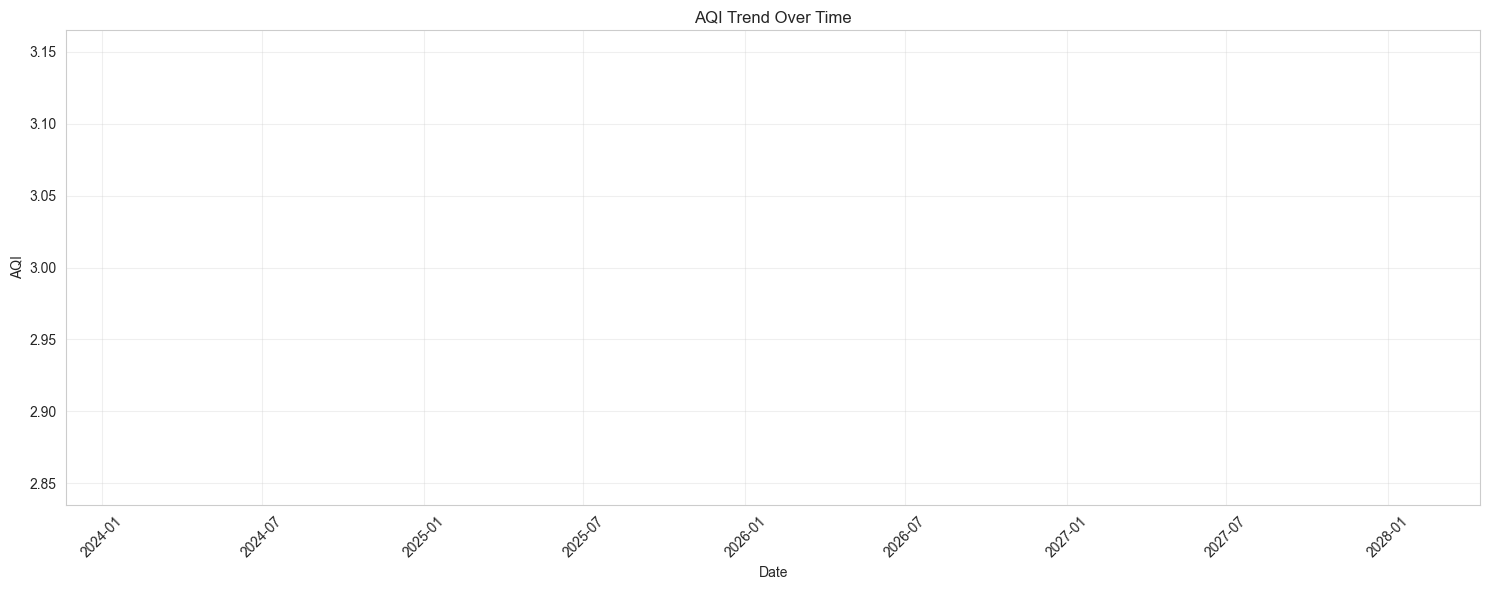

In [11]:
# AQI over time
plt.figure(figsize=(15, 6))
plt.plot(df_real['timestamp'], df_real['aqi'], alpha=0.7)
plt.xlabel('Date')
plt.ylabel('AQI')
plt.title('AQI Trend Over Time')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 4️⃣ Pollutant Analysis

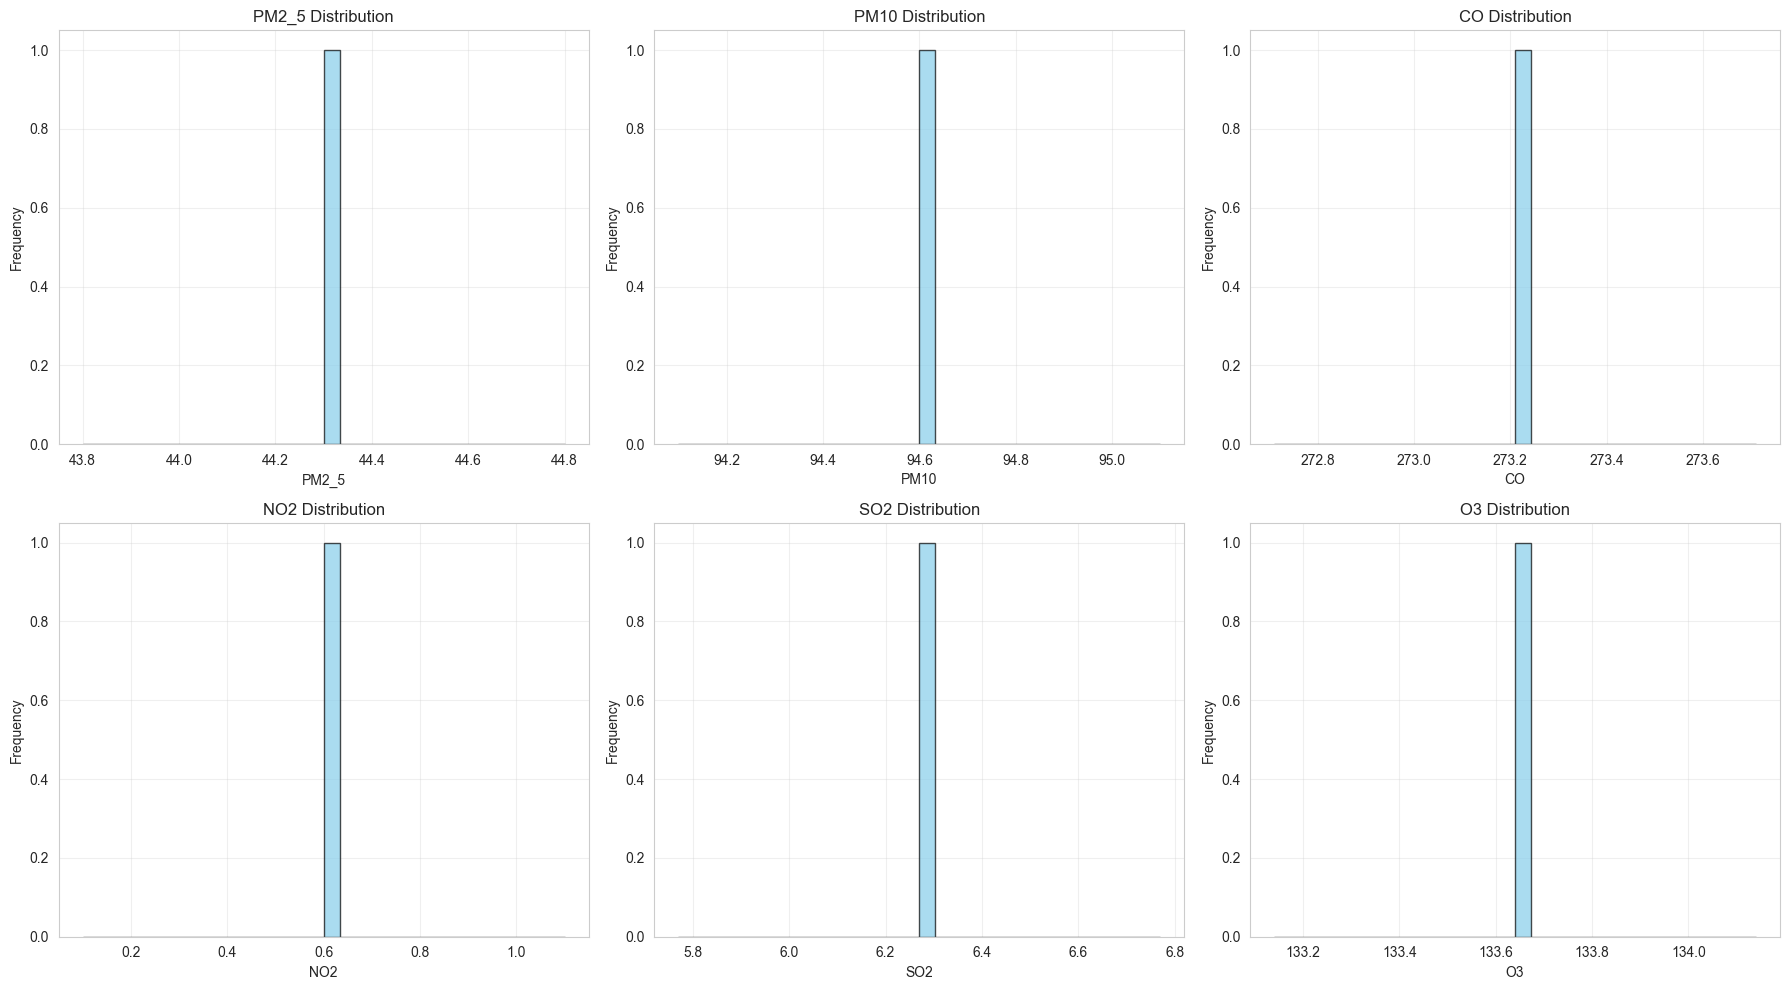

In [12]:
# Pollutant distributions
pollutants = ['pm2_5', 'pm10', 'co', 'no2', 'so2', 'o3']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, pollutant in enumerate(pollutants):
    data = df_real[pollutant]
    axes[i].hist(data, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
    axes[i].set_xlabel(pollutant.upper())
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'{pollutant.upper()} Distribution')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5️⃣ Weather Analysis

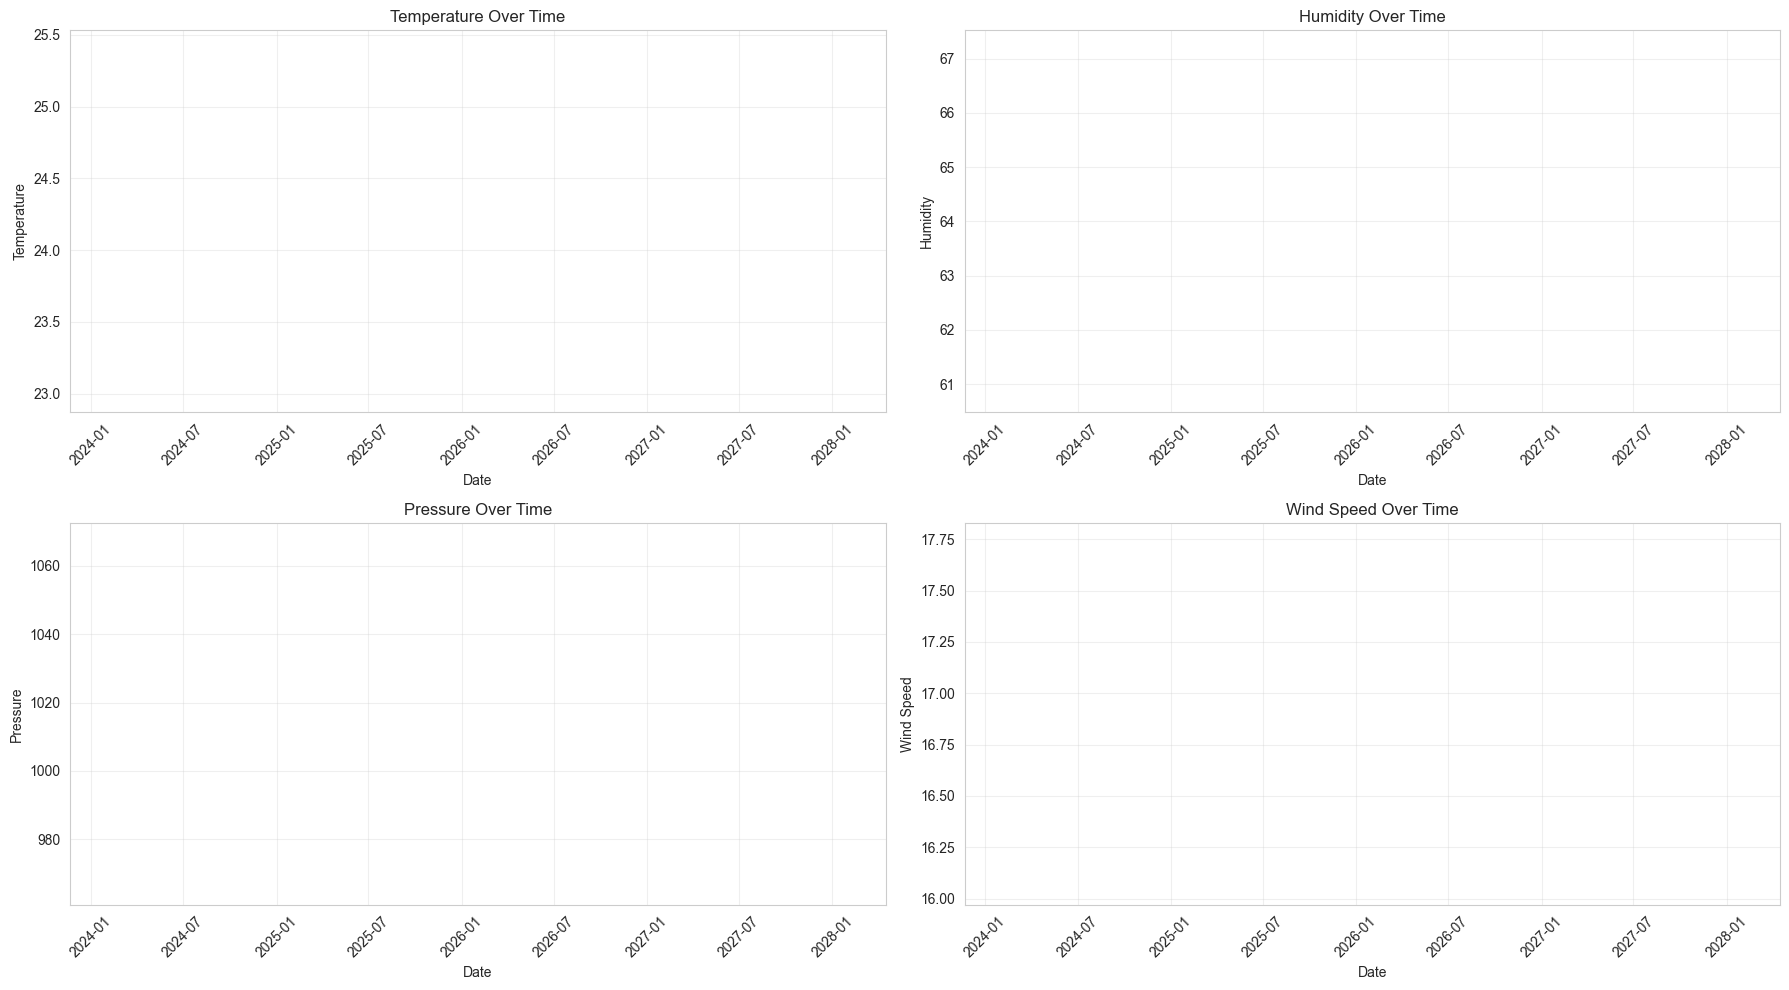

In [13]:
# Weather variables over time
weather_vars = ['temperature', 'humidity', 'pressure', 'wind_speed']

fig, axes = plt.subplots(2, 2, figsize=(18, 10))
axes = axes.flatten()

for i, var in enumerate(weather_vars):
    axes[i].plot(df['timestamp'], df[var], alpha=0.7, color='orange')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(var.replace('_', ' ').title())
    axes[i].set_title(f'{var.replace("_", " ").title()} Over Time')
    axes[i].grid(True, alpha=0.3)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 6️⃣ Correlation Analysis

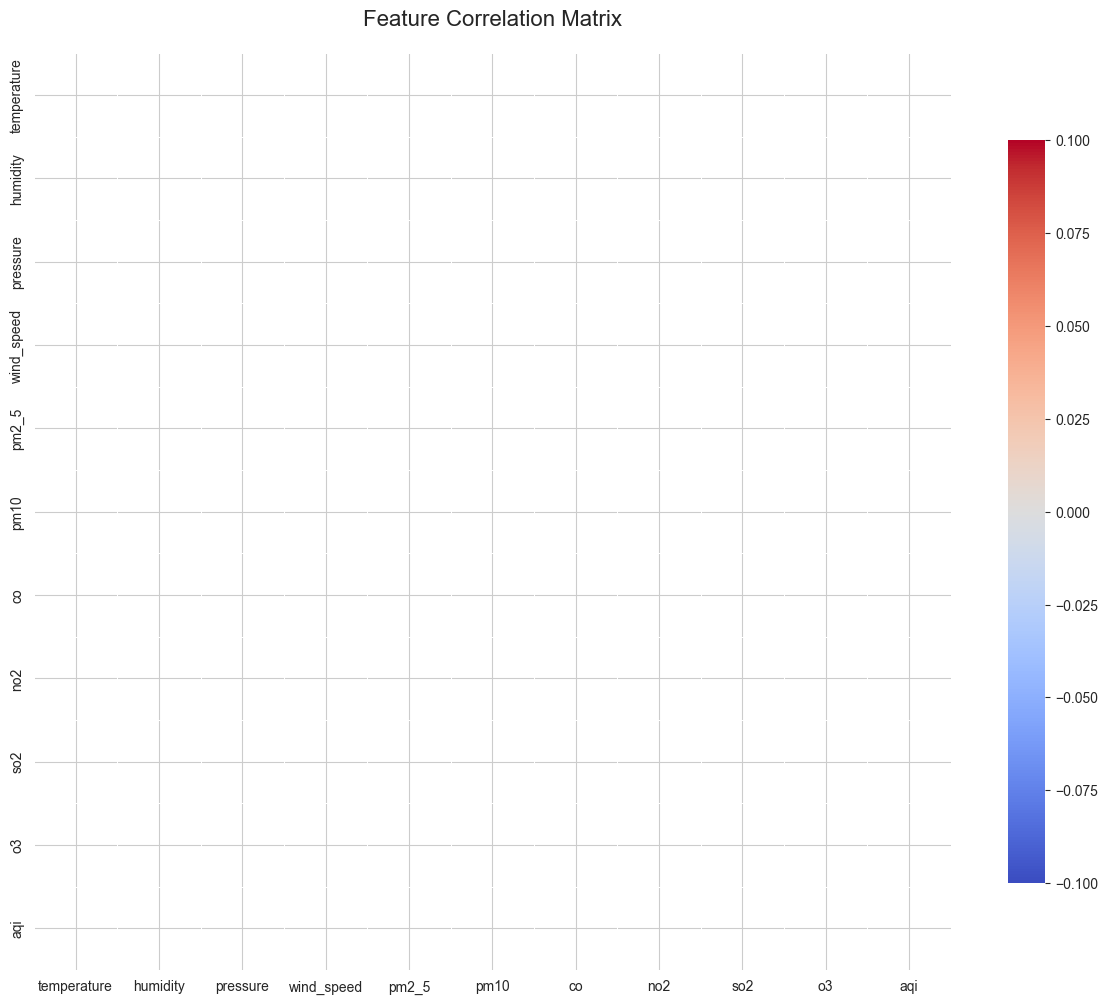

In [14]:
# Select numeric columns for correlation
numeric_cols = ['temperature', 'humidity', 'pressure', 'wind_speed',
                'pm2_5', 'pm10', 'co', 'no2', 'so2', 'o3', 'aqi']

# Calculate correlation matrix
corr_matrix = df_real[numeric_cols].corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

In [15]:
# Top correlations with AQI
aqi_corr = corr_matrix['aqi'].sort_values(ascending=False)
print("Correlations with AQI:")
print(aqi_corr)

Correlations with AQI:
temperature   NaN
humidity      NaN
pressure      NaN
wind_speed    NaN
pm2_5         NaN
pm10          NaN
co            NaN
no2           NaN
so2           NaN
o3            NaN
aqi           NaN
Name: aqi, dtype: float64


## 7️⃣ Time-Based Patterns

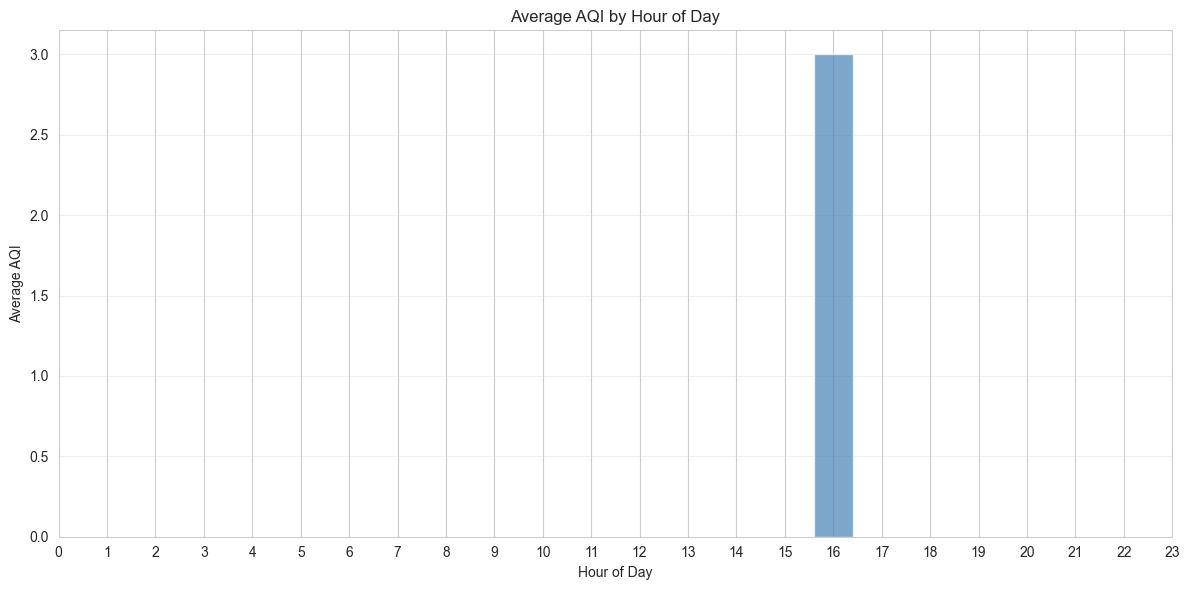

In [16]:
# AQI by hour of day
if len(df_real) > 0:
    hourly_aqi = df_real.groupby('hour')['aqi'].mean().sort_index()
    
    plt.figure(figsize=(12, 6))
    plt.bar(hourly_aqi.index, hourly_aqi.values, color='steelblue', alpha=0.7)
    plt.xlabel('Hour of Day')
    plt.ylabel('Average AQI')
    plt.title('Average AQI by Hour of Day')
    plt.xticks(range(0, 24))
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

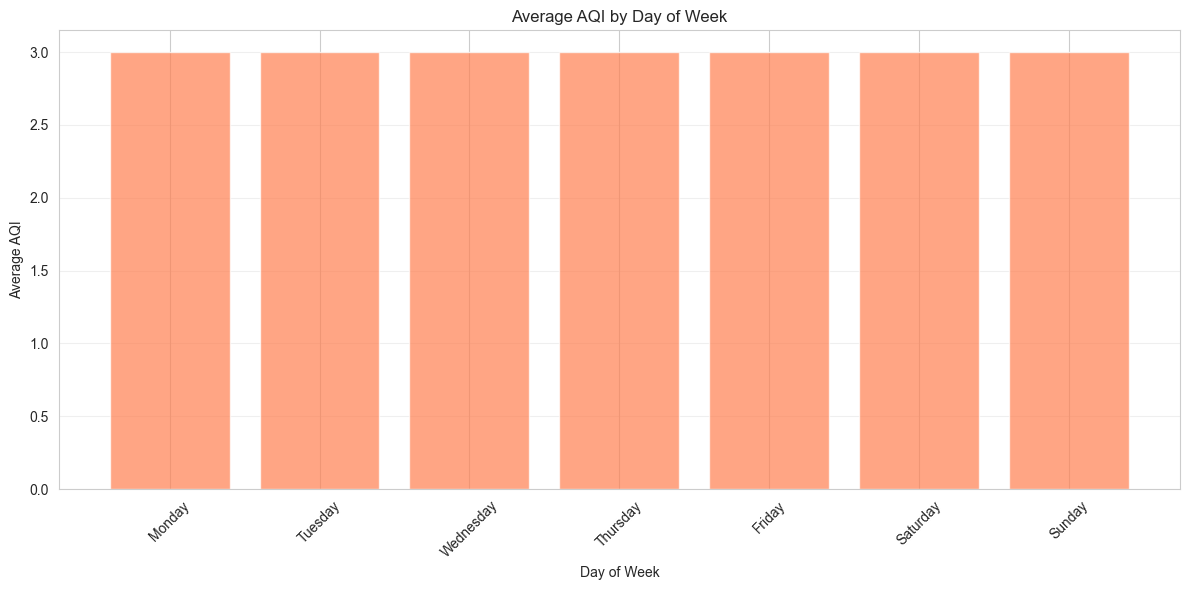

In [17]:
# AQI by day of week
if len(df_real) > 0:
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    daily_aqi = df_real.groupby('day_of_week')['aqi'].mean().sort_index()
    
    plt.figure(figsize=(12, 6))
    plt.bar(range(7), daily_aqi.values, color='coral', alpha=0.7)
    plt.xlabel('Day of Week')
    plt.ylabel('Average AQI')
    plt.title('Average AQI by Day of Week')
    plt.xticks(range(7), days, rotation=45)
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

## 8️⃣ Key Insights

Based on the EDA, document your findings here:

1. **Data Quality**: 
2. **AQI Patterns**: 
3. **Pollutant Relationships**: 
4. **Weather Impact**: 
5. **Temporal Patterns**: 
6. **Recommendations for Model**:

In [18]:
# Save cleaned data if needed
# df_real.to_csv('cleaned_aqi_data.csv', index=False)
print("✓ EDA Complete!")

✓ EDA Complete!
